# Import Libs

In [ ]:
!pip install pandas-profiling
!pip install --upgrade pydantic
!pip install pydantic==1.8.2
!pip install catboost

In [4]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import pandas_profiling as pdp

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# Data loading and overview

In [5]:
df = pd.read_csv(r'/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.shape

(5110, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
df.dropna(inplace = True)

In [10]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
for i in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(df[i].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


# EDA

## BOXPLOT

<Axes: xlabel='stroke', ylabel='smoking_status'>

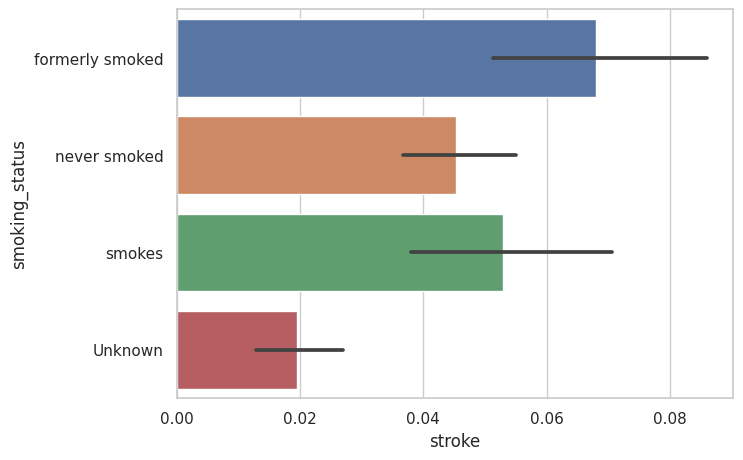

In [12]:
sns.barplot(x = 'stroke', y = 'smoking_status', data = df)

'Unknown' and 'never smoker' has a low percentage of strokes in the sample. Let's combine them into one group: 'never smoker'.

In [13]:
replace_values = {'Unknown': 'never smoked'}

df = df.replace({'smoking_status': replace_values})
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


<Axes: xlabel='smoking_status', ylabel='age'>

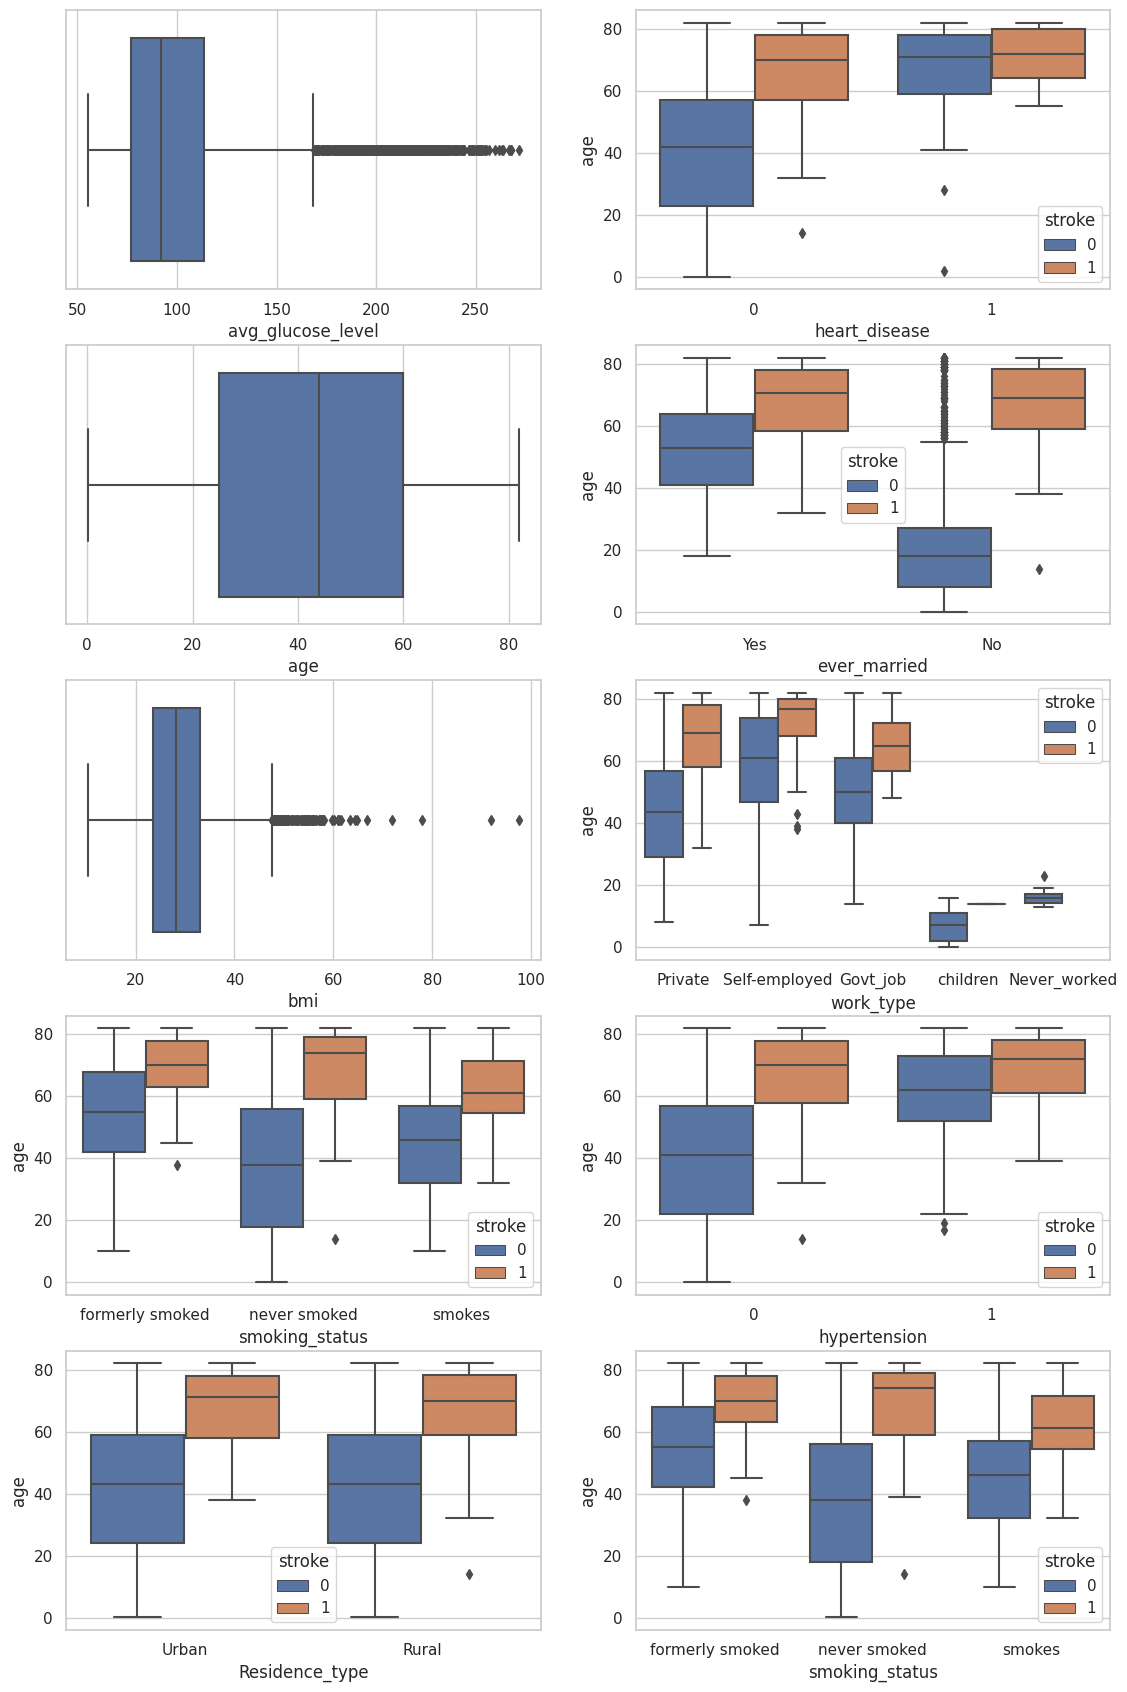

In [14]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20))
sns.boxplot(x = 'avg_glucose_level', data = df, ax=axes[0][0])
sns.boxplot(x = 'age', data = df, ax=axes[1][0])
sns.boxplot(x = 'bmi', data = df, ax=axes[2][0])
sns.boxplot(x = 'smoking_status', y = 'age', hue = 'stroke', data = df, ax=axes[3][0])
sns.boxplot(x = 'hypertension',y = 'age', hue = 'stroke', data = df, ax=axes[3][1])
sns.boxplot(x = 'heart_disease', y= 'age', hue = 'stroke', data = df, ax=axes[0][1])
sns.boxplot(x = 'ever_married',y = 'age', hue = 'stroke', data = df, ax = axes[1][1])
sns.boxplot(x = 'work_type',y = 'age',hue = 'stroke', data = df, ax = axes[2][1])
sns.boxplot(x = 'Residence_type',y = 'age',hue = 'stroke', data = df, ax = axes[4][0])
sns.boxplot(x = 'smoking_status',y = 'age', hue = 'stroke', data = df, ax = axes[4][1])

Good insights :)

We have oultiers in avg_glucose_level and bmi.

### Remove outliers

In [15]:
### Thanks for the function https://www.kaggle.com/ankitak46

def remove_outliers(data):
    arr=[]
    #print(max(list(data)))
    q1=np.percentile(data,25)
    q3=np.percentile(data,75)
    iqr=q3-q1
    mi=q1-(1.5*iqr)
    ma=q3+(1.5*iqr)
    #print(mi,ma)
    for i in list(data):
        if i<mi:
            i=mi
            arr.append(i)
        elif i>ma:
            i=ma
            arr.append(i)
        else:
            arr.append(i)
    #print(max(arr))
    return arr

In [16]:
df['bmi'] = remove_outliers(df['bmi'])
df['avg_glucose_level'] = remove_outliers(df['avg_glucose_level'])
print('Outliers successfully removed')

Outliers successfully removed


<Axes: xlabel='avg_glucose_level'>

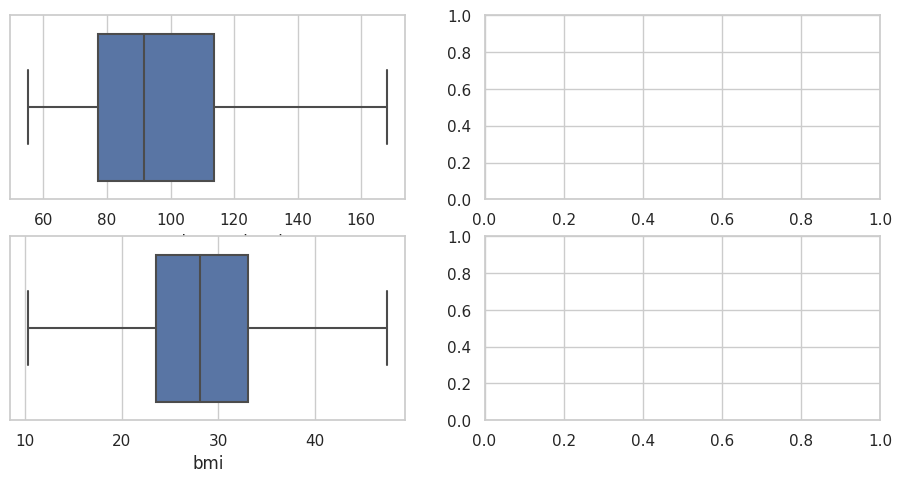

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 5))
sns.boxplot(x = 'bmi', data = df, ax=axes[1][0])
sns.boxplot(x = 'avg_glucose_level', data = df, ax=axes[0][0])

In [18]:
df = df.drop('id', axis = 1)

In [19]:
df.shape

(4909, 11)

# Preprocessing

In [20]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2=LabelEncoder()
df['Residence_type'] = le1.fit_transform(df['Residence_type'])
df['ever_married'] = le2.fit_transform(df['ever_married'])

In [21]:
import joblib
joblib.dump(le1,"res_transform")
joblib.dump(le2,"mar_transform")

['mar_transform']

In [22]:
df.shape

(4909, 11)

In [23]:
df.iloc[0,:]

gender                          Male
age                             67.0
hypertension                       0
heart_disease                      1
ever_married                       1
work_type                    Private
Residence_type                     1
avg_glucose_level             168.32
bmi                             36.6
smoking_status       formerly smoked
stroke                             1
Name: 0, dtype: object

In [24]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,168.32,36.6,formerly smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,168.32,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,168.32,24.0,never smoked,1
5,Male,81.0,0,0,1,Private,1,168.32,29.0,formerly smoked,1


In [25]:
X = df.iloc[:,0:10].values
y = df.iloc[:,10].values

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct= ColumnTransformer([("onehot",OneHotEncoder(drop='first'),[0,5,9])],remainder="passthrough")
X=ct.fit_transform(X)

In [27]:
joblib.dump(ct,"column")

['column']

In [28]:
X

array([[1.0, 0.0, 0.0, ..., 1, 168.32, 36.6],
       [1.0, 0.0, 0.0, ..., 0, 105.92, 32.5],
       [0.0, 0.0, 0.0, ..., 1, 168.32, 34.4],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 82.99, 30.6],
       [1.0, 0.0, 0.0, ..., 0, 166.29, 25.6],
       [0.0, 0.0, 0.0, ..., 1, 85.28, 26.2]], dtype=object)

In [29]:
X[0]

array([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0, 1, 1, 1, 168.32,
       36.6], dtype=object)

# Model

In [30]:
X.shape

(4909, 15)

In [31]:
y.shape

(4909,)

### We use sampling because there is an imbalance of the target feature

<Axes: ylabel='count'>

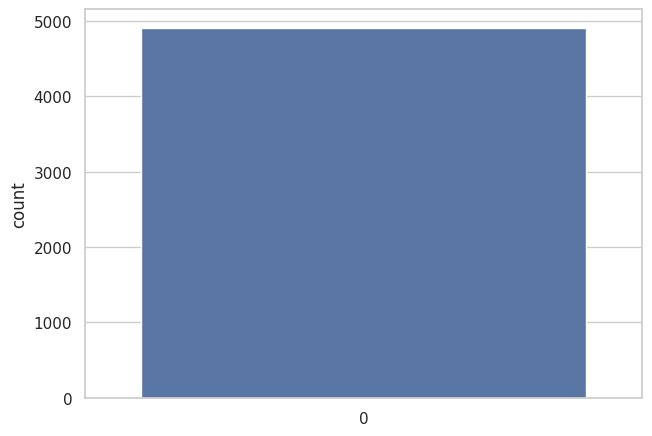

In [32]:
### before oversampling

sns.countplot(y)

In [33]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

Before OverSampling, counts of label '1': 209
Before OverSampling, counts of label '0': 4700 

After OverSampling, the shape of train_X: (9400, 15)
After OverSampling, the shape of train_y: (9400,) 

After OverSampling, counts of label '1': 4700
After OverSampling, counts of label '0': 4700


<Axes: ylabel='count'>

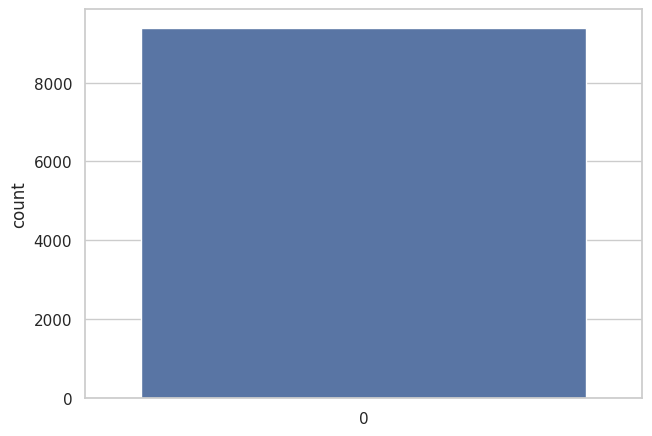

In [34]:
### after oversampling

sns.countplot(y_res)

Oversampling is successful

# Modeling

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

## Decision Tree

In [36]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print(confusion_matrix(dtc_pred, y_test))
print('-----')
print(classification_report(dtc_pred, y_test))

[[860  41]
 [ 62 917]]
-----
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       901
           1       0.96      0.94      0.95       979

    accuracy                           0.95      1880
   macro avg       0.94      0.95      0.95      1880
weighted avg       0.95      0.95      0.95      1880



## Random Forest

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(confusion_matrix(rf_pred, y_test))
print('-----')
print(classification_report(rf_pred, y_test))

[[914  41]
 [  8 917]]
-----
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       955
           1       0.96      0.99      0.97       925

    accuracy                           0.97      1880
   macro avg       0.97      0.97      0.97      1880
weighted avg       0.97      0.97      0.97      1880



### It's best F1 score

## Logistic Regression

In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(confusion_matrix(lr_pred, y_test))
print('-----')
print(classification_report(lr_pred, y_test))

[[693 195]
 [229 763]]
-----
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       888
           1       0.80      0.77      0.78       992

    accuracy                           0.77      1880
   macro avg       0.77      0.77      0.77      1880
weighted avg       0.78      0.77      0.77      1880



## SVC

In [39]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print(confusion_matrix(svc_pred, y_test))
print('-----')
print(classification_report(svc_pred, y_test))

[[655 174]
 [267 784]]
-----
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       829
           1       0.82      0.75      0.78      1051

    accuracy                           0.77      1880
   macro avg       0.76      0.77      0.76      1880
weighted avg       0.77      0.77      0.77      1880



## KNN

In [40]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(confusion_matrix(knn_pred, y_test))
print('-----')
print(classification_report(knn_pred, y_test))

[[757  15]
 [165 943]]
-----
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       772
           1       0.98      0.85      0.91      1108

    accuracy                           0.90      1880
   macro avg       0.90      0.92      0.90      1880
weighted avg       0.92      0.90      0.91      1880



# Grid Search

In [41]:
cross_valid_scores = {}

## Random Forest

In [43]:
%%time
parameters = {
    "n_estimators": [5, 10, 15, 20, 25],
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
)

model_rf = GridSearchCV(
    model_rf,
    parameters,
    cv=5,
)

model_rf.fit(X_train, y_train)
model_rf_pred = model_rf.predict(X_test)
print(classification_report(model_rf_pred, y_test))

print('-----')
print(f'Best parameters {model_rf.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_rf.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_rf.best_score_
print('-----')

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       955
           1       0.95      0.99      0.97       925

    accuracy                           0.97      1880
   macro avg       0.97      0.97      0.97      1880
weighted avg       0.97      0.97      0.97      1880

-----
Best parameters {'max_depth': 13, 'n_estimators': 20}
Mean cross-validated accuracy score of the best_estimator: 0.973
-----
CPU times: user 16.6 s, sys: 117 ms, total: 16.7 s
Wall time: 25.2 s


In [44]:
import pickle
with open("modelor.pkl", "wb") as f:
    pickle.dump(model_rf, f)

Confusion Matrix:
[[914  41]
 [  8 917]]
-----
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       955
           1       0.96      0.99      0.97       925

    accuracy                           0.97      1880
   macro avg       0.97      0.97      0.97      1880
weighted avg       0.97      0.97      0.97      1880



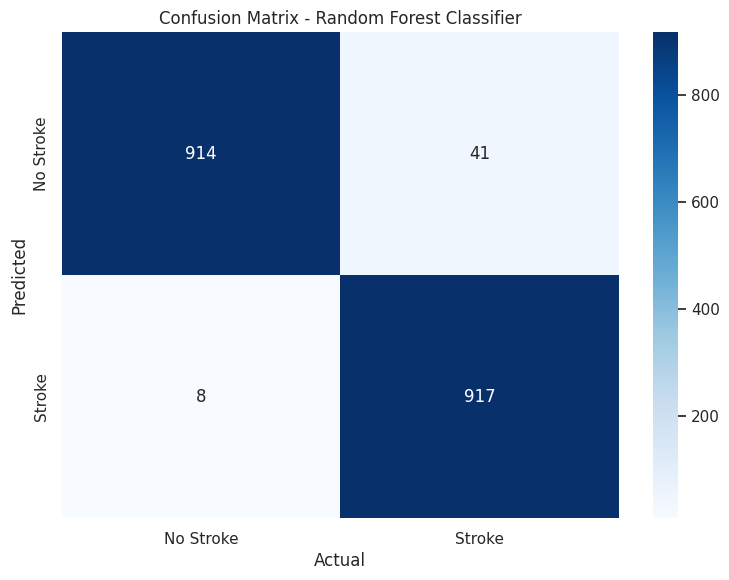

In [51]:
cm = confusion_matrix(rf_pred, y_test)
print("Confusion Matrix:")
print(cm)
print('-----')
print("Classification Report:")
print(classification_report(rf_pred, y_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

# Thank for watching!